# Denotation

* $n_i$ : # input channels for $i$th conv layer.
* $h_i/w_i$ : the height/width of the input feature maps.
* The conv layer transforms the input feature maps($x_i$ $\in$ $R^{n_i \times h_i \times w_i}$) into the output feature maps ($x_{i+1}$ $\in$ $R^{n_{i+1} \times h_{i+1} \times w_{i+1}}$), which are used as input feature maps for the next conv layer.
   * This is achieved by applying $n_{i+1}$ 3D filters $F_{i, j}$ $\in$ $R^{n_i \times k \times k}$ on the $n_i$ input channels, in which one filter generates one feature map.
 * Each filter is composed by $n_i$ 2D kernels $K \in R^{k \times k}$.
 * All the filters, togethers, consititue the kernel matrix $F_i \in R^{n_i \times n_{i+1} \times k \times k}$.
* the number of operations of the conv layer is $n_{i+1} n_i k^2 h_{i+1} w_{i+1}$.
  * when a filter $F_{i, j}$ is pruned, its corresponding feature map $x_{i+1, j}$ is removed, which reduces  $n_{i} k^2 h_{i+1} w_{i+1}$ operations.
  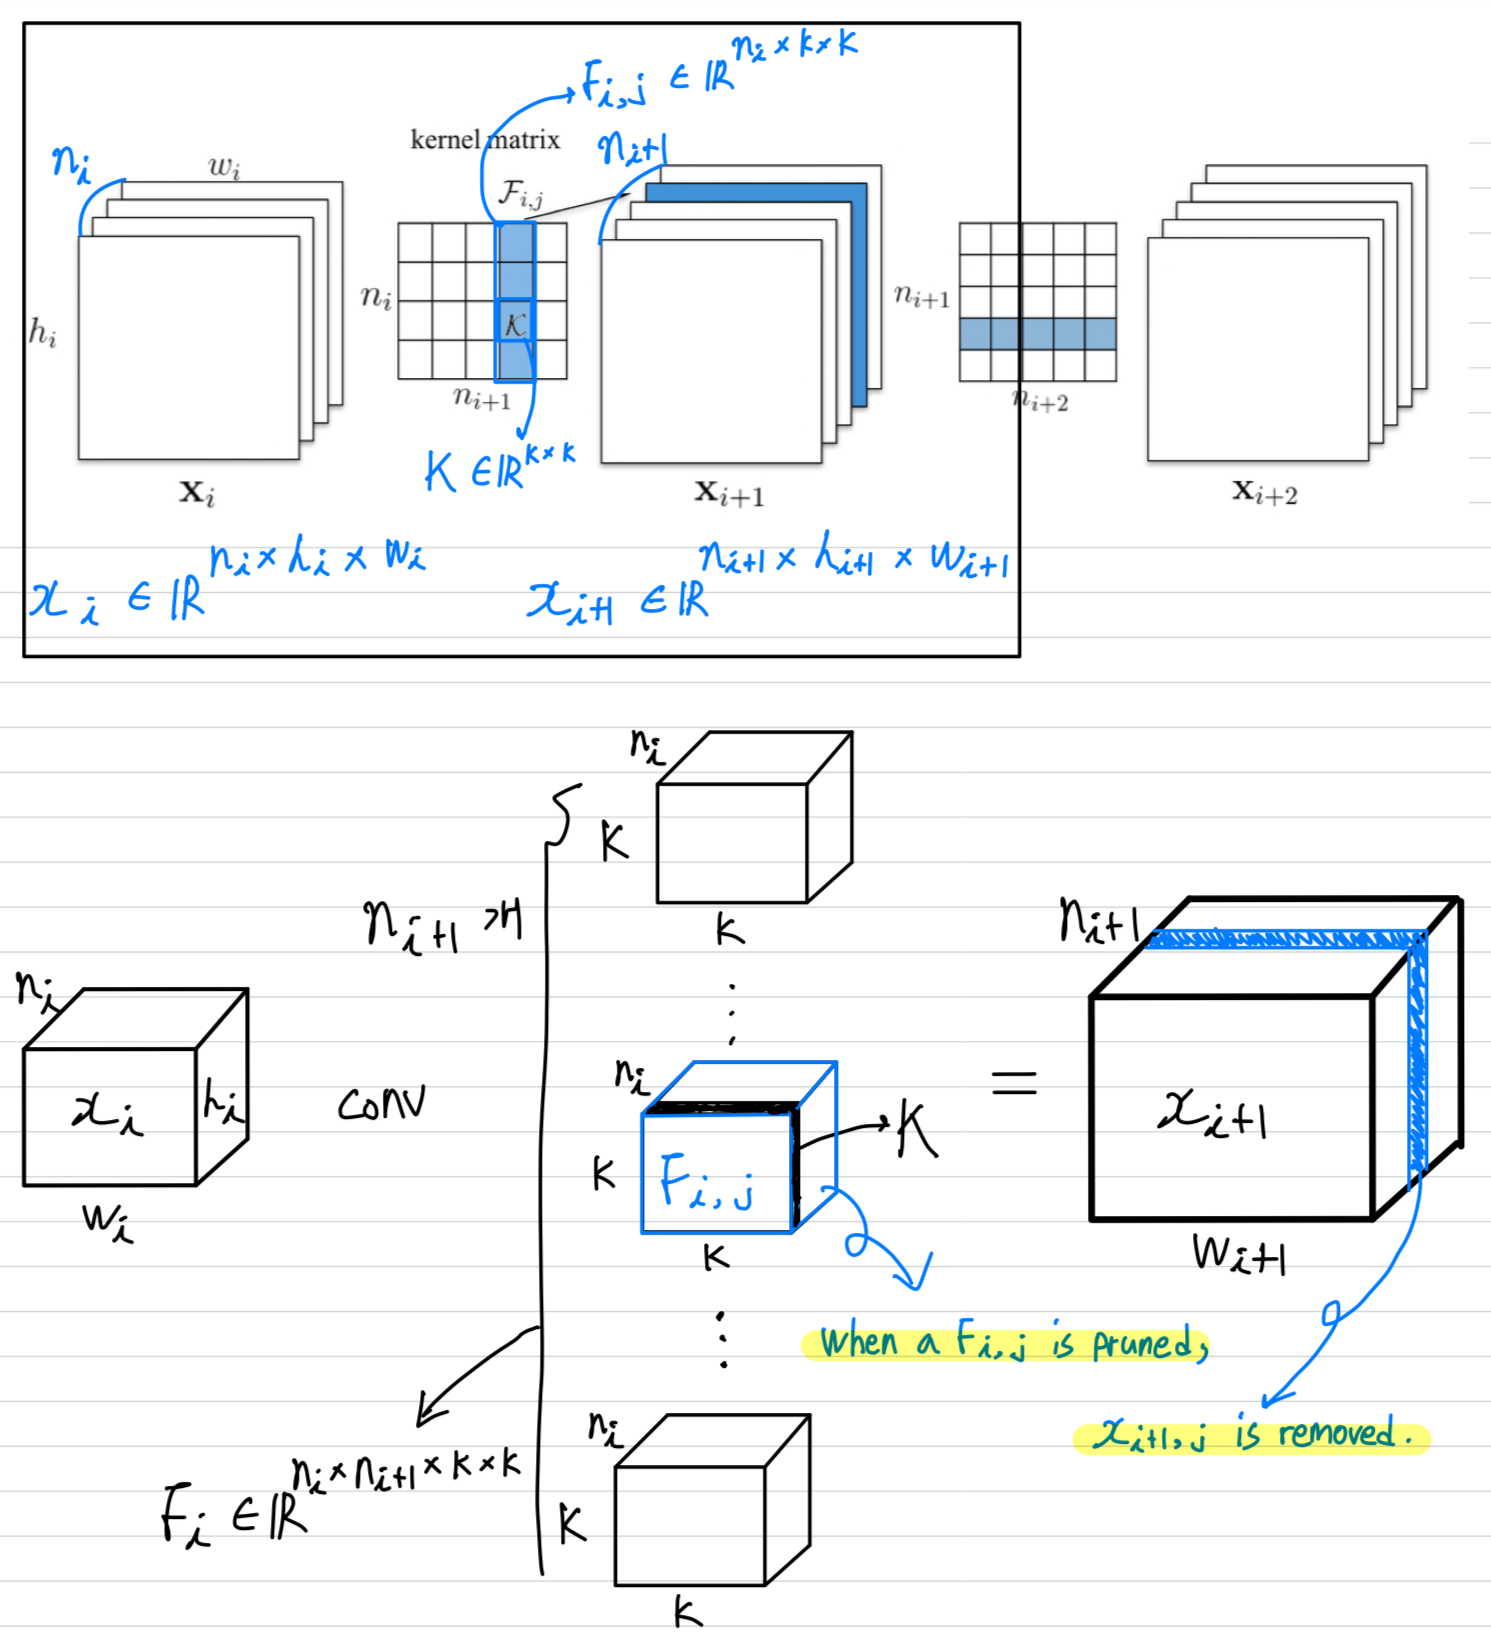

# Determining which filters to prune within a single layer

* Our method prunes the less useful filters from a well-trained model for computational efficiency while minimizing the accuracy drop.
* We `measure` the relative importance of a filter in each layer by calculating the sum of its absolute weights $\Sigma|F_{i, j}|$, i.e., its **$l_1$-norm $||F_{i, j}||$**.
  * Filters with smaller kernel weights tend to produce feature maps with weak activations as compared to the other filters in that layer.

* Figure 2(a) illustrates the distribution of filter's abs weights sum for each conv layer in a VGG-16 network trained on the CIFAR-10, where the distribution varies significantly across layer.
  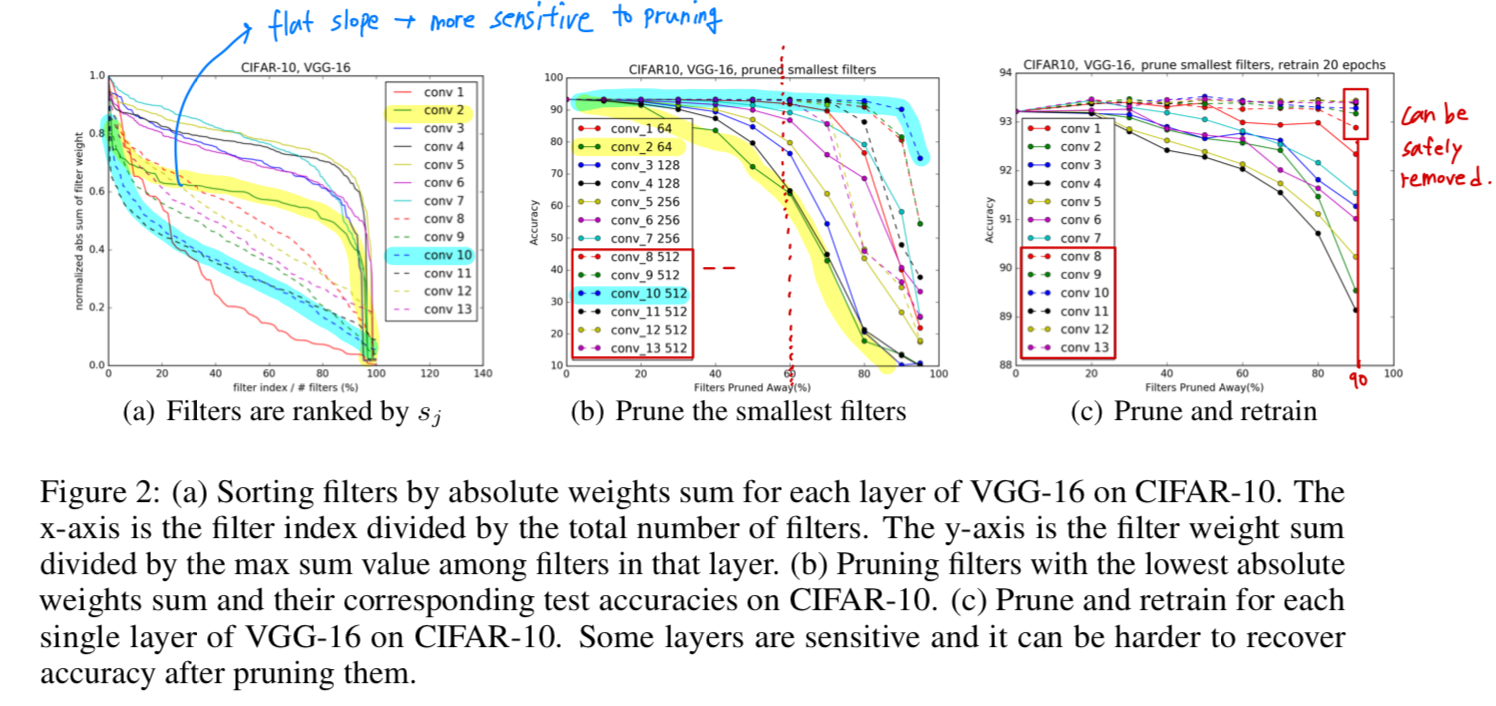

# 1. [baseline model] VGG-16 on CIFAR-10 model (by Ioffe & Szegedy)

* VGG-16 on CIFAR-10 consists of 13 conv layers and 2 fc layers.
* Szegedy model(http://torch.ch/blog/2015/07/30/cifar.html > https://github.com/szagoruyko/cifar.torch)에 `Batch Normalization` 추가
  * after each conv layer and the first fc layer, without using Dropout.
    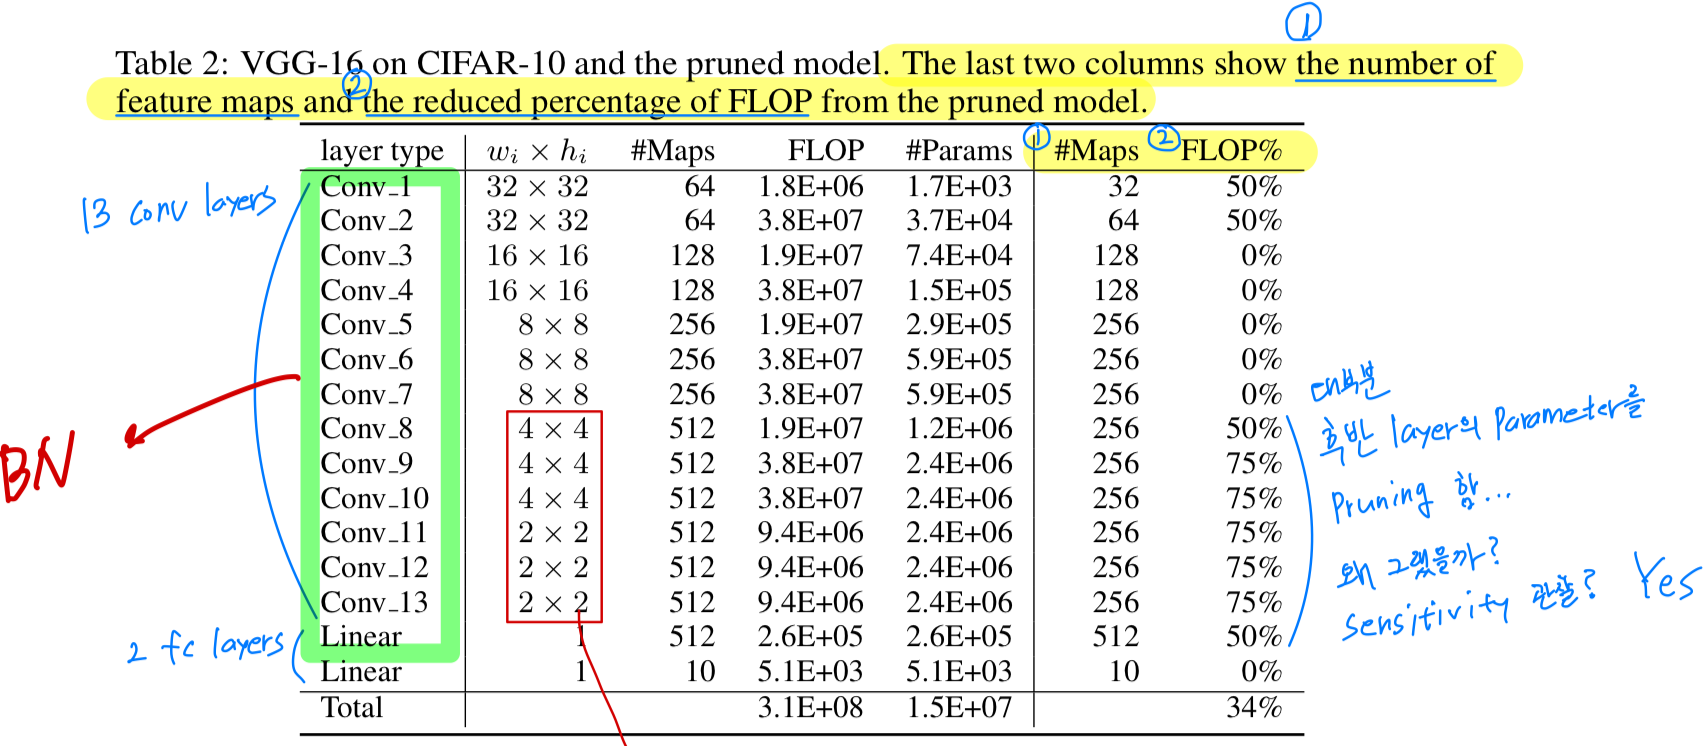
* Note that when the last convolutional layer is pruned, the input to the linear layer is changed and the connections are also removed.    

In [19]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import tensorflow as tf

import torch.optim as optim
from torch.optim import lr_scheduler

import torch.nn.init as init
import kornia
import math

## Preprocessing

In [20]:
# the image are converted to YUV and mean-std normalization is applied
def rgb_to_yuv(image) :
    kornia.color.rgb_to_yuv(image)
    return image

trainset = torchvision.datasets.CIFAR10(
    root='/home/hslee/Desktop/Datasets/', 
    train=True,
    download=True, 
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),        
        rgb_to_yuv,
    ])
)
batch_size = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8, pin_memory=True)

# calculate batch's mean and std
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
mean /= nb_samples
std /= nb_samples
print(mean, std)

'''
result : tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])
'''

Files already downloaded and verified
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


'\nresult : tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])\n'

In [21]:
# https://github.com/szagoruyko/cifar.torch/blob/master/provider.lua

batch_size = 128

# the image are converted to YUV and mean-std normalization is applied
def rgb_to_yuv(image) :
    kornia.color.rgb_to_yuv(image)
    return image

trainset = torchvision.datasets.CIFAR10(
    root='/home/hslee/Desktop/Datasets/', 
    train=True,
    download=True, 
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),        
        rgb_to_yuv,
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8, pin_memory=True)

valset = torchvision.datasets.CIFAR10(
    root='/home/hslee/Desktop/Datasets/', 
    train=False,
    download=True, 
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        rgb_to_yuv,
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# the number of training data
trsize = trainset.__len__()
print(trsize)
tesize = valset.__len__()
print(tesize)

50000
10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mini batch shape : torch.Size([128, 3, 32, 32])


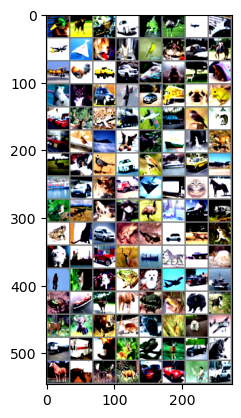

bird  deer  bird  car   frog  bird  plane plane plane plane dog   cat   bird  frog  plane horse plane bird  car   car   horse frog  deer  cat   dog   cat   car   plane car   truck dog   frog  truck deer  frog  truck plane car   bird  cat   car   bird  plane dog   deer  ship  dog   deer  deer  cat   bird  car   bird  ship  car   plane ship  car   deer  truck plane truck cat   horse bird  plane deer  bird  bird  truck plane frog  frog  cat   car   frog  frog  car   deer  frog  dog   ship  car   deer  ship  horse plane deer  bird  cat   dog   frog  dog   plane truck ship  frog  ship  deer  horse frog  frog  dog   dog   deer  deer  car   deer  cat   deer  dog   plane truck truck cat   deer  bird  deer  car   cat   horse horse deer  deer  car   car   bird  car  


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"mini batch shape : {images.shape}")
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## architecture

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [24]:
class VGG16_BN(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv2
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True), 
                ## [lua code] vgg:add(MaxPooling(kW=2, kH=2, dW=2, dH=2, padW=0, padH=0):ceil())
                ## --> https://github.com/torch/nn/blob/master/SpatialMaxPooling.lua
            # conv3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv4
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True), 
            # conv5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv6
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv7
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True), 
            # conv8
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv9
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv10
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            # conv11
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv12
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # conv13
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
        )
        self.fc_layers = nn.Sequential(
            # fc1
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # fc2
            nn.Linear(512, 10, bias=True),
        )
    
    def forward(self, x) :
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [25]:
from pytorch_model_summary import summary

model = VGG16_BN()
print(summary(model, torch.zeros((128, 3, 32, 32)), show_input=True, show_hierarchical=True))

model = model.to(device)

--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1       [128, 3, 32, 32]           1,792           1,792
     BatchNorm2d-2      [128, 64, 32, 32]             128             128
            ReLU-3      [128, 64, 32, 32]               0               0
          Conv2d-4      [128, 64, 32, 32]          36,928          36,928
     BatchNorm2d-5      [128, 64, 32, 32]             128             128
            ReLU-6      [128, 64, 32, 32]               0               0
       MaxPool2d-7      [128, 64, 32, 32]               0               0
          Conv2d-8      [128, 64, 16, 16]          73,856          73,856
     BatchNorm2d-9     [128, 128, 16, 16]             256             256
           ReLU-10     [128, 128, 16, 16]               0               0
         Conv2d-11     [128, 128, 16, 16]         147,584         147,584
    BatchNorm2d-12     [128, 128, 16,

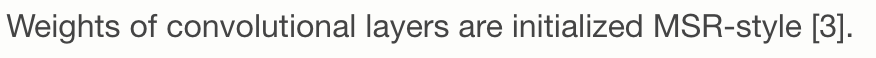

In [26]:
# kaiming initialization
def init_weights(m) :
    if isinstance(m, nn.Conv2d) :
        init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
        
# check the weight initialization
model.apply(init_weights)

# check the Normalization
for name, layer in model.named_modules() :
    if isinstance(layer, nn.Conv2d) :
        print(f"{name} : {layer.weight.data[0, 0, 0, 0]}")
        # mean, std, variance
        print(f"{name} : {layer.weight.data.mean()}, {layer.weight.data.std()}, {layer.weight.data.var()}")

conv_layers.0 : -0.013229383155703545
conv_layers.0 : 0.0005187325878068805, 0.05926908552646637, 0.0035128246527165174
conv_layers.3 : -0.04103945568203926
conv_layers.3 : 0.0002106058964272961, 0.05882246047258377, 0.00346008175984025
conv_layers.7 : 0.06777055561542511
conv_layers.7 : 0.00012304895790293813, 0.04152700677514076, 0.0017244921764358878
conv_layers.10 : 0.0653126984834671
conv_layers.10 : -9.819425940804649e-06, 0.04173874482512474, 0.0017421229276806116
conv_layers.14 : -0.018981236964464188
conv_layers.14 : 5.054898065282032e-05, 0.029379447922110558, 0.0008631519158370793
conv_layers.17 : -0.014457345008850098
conv_layers.17 : 1.2768367923854385e-05, 0.029458062723279, 0.0008677774458192289
conv_layers.20 : -0.013208635151386261
conv_layers.20 : 3.6105109757045284e-05, 0.02943386323750019, 0.0008663523476570845
conv_layers.24 : 0.0034764816518872976
conv_layers.24 : 8.738204996916465e-06, 0.020860208198428154, 0.0004351483075879514
conv_layers.27 : -0.02713176421821

In [27]:
# check # of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"# of total parameters : {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# of trainable parameters : {total_trainable_params}")

# of total parameters : 14991946
# of trainable parameters : 14991946


## hyper parameters & optimizer

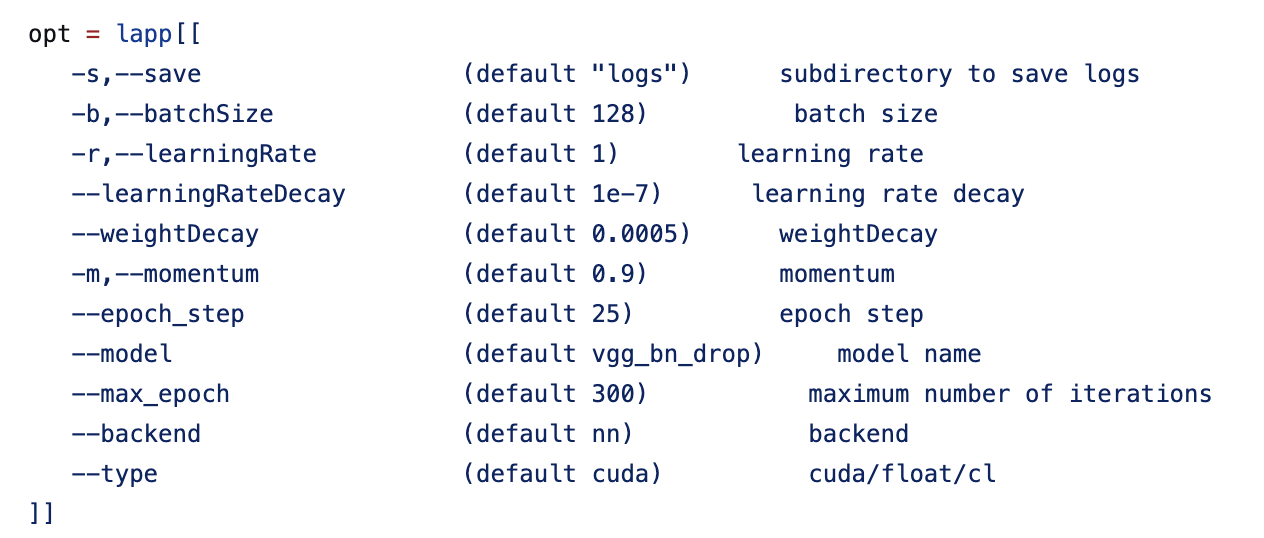

In [9]:
batch_size = 128
lr = 1
lr_decay = 1e-7
weight_decay = 0.0005
momentum = 0.9
epoch_step = 25                    # [lua code] :  drop learning rate every "epoch_step" epochs (optimState.learningRate = optimState.learningRate/2)
epochs = 300

criterion = nn.CrossEntropyLoss() # [lua code] : criterion = cast(nn.CrossEntropyCriterion())
# https://github.com/torch/optim/blob/master/sgd.lua
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(epoch_step, epochs, epoch_step), gamma=0.5, verbose=True)
print(np.arange(epoch_step, epochs, epoch_step))



Adjusting learning rate of group 0 to 1.0000e+00.
[ 25  50  75 100 125 150 175 200 225 250 275]


## Training & Parameters

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/vgg16_baseline_exp1')
input_tensor = torch.Tensor(128, 3, 32, 32).to(device)
writer.add_graph(model, input_tensor)

In [11]:
num_val_batches = len(val_loader)
print(f"# of validation batches : {num_val_batches}")

# of validation batches : 79


In [12]:
val_acc_list = []
val_loss_list = []

for epoch in range(1, epochs+1) :
    model.train()
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0) :
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    writer.add_scalar('training loss', training_loss/(i+1), epoch)
    writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch)
    print(f"epoch : {epoch:03d} / {epochs:03d} | train loss : {training_loss/(i+1):.5f}")
    lr_scheduler.step()

    if epoch % 5 == 0 :
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad() :
            for i, data in enumerate(val_loader, 0) :
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_acc = 100 * (correct/total)
        val_acc_list.append(val_acc)
        val_loss = val_loss/(num_val_batches)
        val_loss_list.append(val_loss)
        
        writer.add_scalar('val acc', val_acc, epoch)
        writer.add_scalar('val loss', val_loss, epoch)
        print(f"epoch : {epoch:03d} / {epochs:03d} | val acc : {val_acc:.3f} | val loss : {val_loss:.5f}")
        
        torch.save({
            'epoch' : epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'loss' : loss,
        }, f"./vgg16_baseline_exp1_checkpoint/epoch_{epoch}.pth")
        if val_loss < min(val_loss_list) :
            torch.save(model.state_dict(), f"./vgg16_baseline_exp1_checkpoint/best_model_epoch_{epoch}.pth")
            print(f"val loss decreased ({min(val_loss_list):.5f} --> {val_loss:.5f}) | saving best model ...")
        

epoch : 001 / 300 | train loss : 2.46056
Adjusting learning rate of group 0 to 1.0000e+00.
